<a href="https://colab.research.google.com/github/Nageswar-Sahoo/Computer-Vision-Project/blob/main/S8/Untitled0_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Nageswar-Sahoo/Computer-Vision-Project.git

Cloning into 'Computer-Vision-Project'...
remote: Enumerating objects: 685, done.
remote: Counting objects: 100% (685/685), done.
remote: Compressing objects: 100% (584/584), done.
remote: Total 685 (delta 431), reused 255 (delta 87), pack-reused 0
Receiving objects: 100% (685/685), 1.90 MiB | 12.11 MiB/s, done.
Resolving deltas: 100% (431/431), done.


In [2]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

     |████████████████████████████████| 117 kB 8.1 MB/s 
     |████████████████████████████████| 948 kB 38.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=64721cad936dd41965c8936a3e4833d3e05463077db3ddfc3359914bf3b84e2f
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
ls

Computer-Vision-Project/  sample_data/


In [ ]:
cd ..

/content/Computer-Vision-Project


In [ ]:
cd content

[Errno 2] No such file or directory: 'content'
/content/Computer-Vision-Project


In [ ]:
rm -rf Computer-Vision-Project

In [2]:
cd Computer-Vision-Project/S8

/content/Computer-Vision-Project/S8


In [3]:
import data_loader.data_loaders as module_data
from parse_config import ConfigParser
from trainer import Trainer
from utils import prepare_device
import torch
import numpy as np
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import logging
import utils.grad_cam as grad_cam
import matplotlib.pyplot as plt

from utils import GradCAM, GuidedBackpropReLUModel
from utils.image import show_cam_on_image
import cv2
import numpy as np
import torch
import model.model as module_arch

SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [4]:
cat model/model.py

import torch
import torch.nn as nn


def resnet34():
    layers = [3, 4, 6, 3]
    model = ResNet(BasicBlock, layers)
    return model

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        super().__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1)

In [5]:
cat config.json

{
    "name": "CIFR10",
    "trainer": {
        "epochs": 40,
        "save_dir": "saved/",
        "save_period": 1,
        "verbosity": 2,
        "monitor": "min val_loss",
        "early_stop": 300,
        "tensorboard": true
    }
}


In [6]:
    logger = logging.getLogger("trian")
    # Read the config.json
    config = ConfigParser.from_args()

    # setup data_loader instances
    data_loader = module_data.CIFRDataLoader(data_dir='data/', batch_size=64, shuffle=True, validation_split=0.1,
                                             num_workers=2, training=True)
    valid_data_loader = data_loader.split_validation()

    print("length")
    print(data_loader.valid_sampler)

    # build model architecture, then print to console
    model = module_arch.resnet34()
    logger.info(model)

    # prepare for (multi-device) GPU training
    n_gpu = 1
    device, device_ids = prepare_device(n_gpu)
    model = model.to(device)
    if len(device_ids) > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)

    # get function handles of loss and metrics
    criterion = module_loss.crossentropyloss
    metrics = [module_metric.accuracy]

    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    lr_scheduler = StepLR(optimizer, step_size=120, gamma=0.1)
    trainer = Trainer(model, criterion, metrics, optimizer,
                      config=config,
                      device=device,
                      data_loader=data_loader,
                      valid_data_loader=valid_data_loader,
                      lr_scheduler=lr_scheduler)

    trainer.train()

Streaming output truncated to the last 5000 lines.
Train Epoch: 21 [31232/45000 (69%)] Loss: 1.402254
Train Epoch: 21 [31744/45000 (71%)] Loss: 1.161171
Train Epoch: 21 [32256/45000 (72%)] Loss: 1.086524
Train Epoch: 21 [32768/45000 (73%)] Loss: 1.177975
Train Epoch: 21 [33280/45000 (74%)] Loss: 1.047089
Train Epoch: 21 [33792/45000 (75%)] Loss: 1.321158
Train Epoch: 21 [34304/45000 (76%)] Loss: 1.126568
Train Epoch: 21 [34816/45000 (77%)] Loss: 1.127217
Train Epoch: 21 [35328/45000 (79%)] Loss: 1.412610
Train Epoch: 21 [35840/45000 (80%)] Loss: 0.966992
Train Epoch: 21 [36352/45000 (81%)] Loss: 0.879149
Train Epoch: 21 [36864/45000 (82%)] Loss: 0.688152
Train Epoch: 21 [37376/45000 (83%)] Loss: 0.971217
Train Epoch: 21 [37888/45000 (84%)] Loss: 1.488510
Train Epoch: 21 [38400/45000 (85%)] Loss: 1.136055
Train Epoch: 21 [38912/45000 (86%)] Loss: 1.252479
Train Epoch: 21 [39424/45000 (88%)] Loss: 1.123771
Train Epoch: 21 [39936/45000 (89%)] Loss: 1.027326
Train Epoch: 21 [40448/45000 (9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


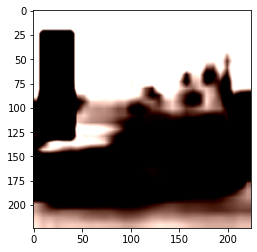

In [219]:
import cv2
import matplotlib.pyplot as plt
im = np.moveaxis(missclassifiedimage[1], 0, 2)
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


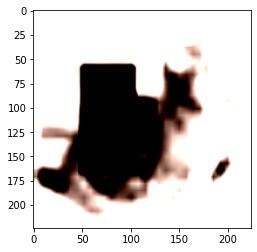

In [220]:
import cv2
import matplotlib.pyplot as plt
im = np.moveaxis(missclassifiedimagecorrect[4], 0, 2)
im_resized = cv2.resize(im, (224, 224), interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

In [7]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=trainer.model
missclassifiedimage=[]
missclassifiedimage_actual_label=[]
missclassifiedimage_predicted_label=[]
with torch.no_grad():
            for batch_idx, (data, target) in enumerate(trainer.valid_data_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability             
                pred=pred.cpu().numpy()
                target=target.cpu().numpy()
                data=data.cpu().numpy()
                for i in range(len(target)):
                    if pred[i] != target[i]:
                        missclassifiedimage.append(data[i])
                        missclassifiedimage_actual_label.append(target[i])
                        missclassifiedimage_predicted_label.append(pred[i][0])

In [10]:
missclassifiedimage_cam=[]
model = trainer.model
target_layers = [model.layer2[-1]]
target_category = None

for i in range(20):
  img = np.moveaxis(missclassifiedimage[i], 0, 2)
  img = np.float32(cv2.resize(img, (32, 32))) / 255
  img_r = np.moveaxis(img, -1, 0)
  preprocessed_img = torch.from_numpy(img_r)
  preprocessed_img.unsqueeze_(0)
  cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
  grayscale_cam = cam(input_tensor=preprocessed_img, target_category=target_category)
  grayscale_cam = grayscale_cam[0, :]
  cam_image_op = show_cam_on_image(img, grayscale_cam, use_rgb=False)
  missclassifiedimage_cam.append(cam_image_op)

0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
1
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
3
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
4
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
5
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
6
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
7
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
8
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for int

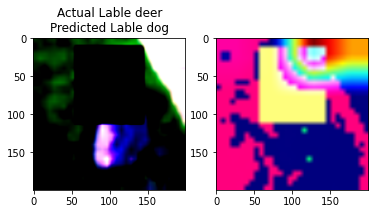

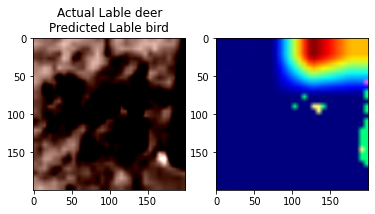

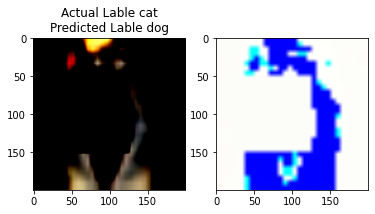

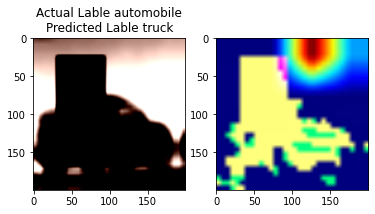

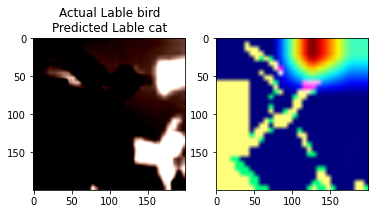

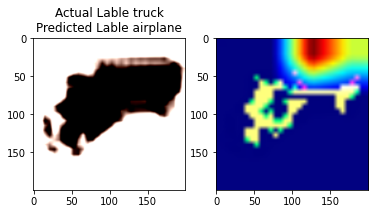

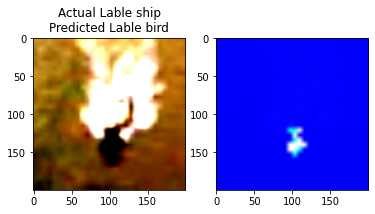

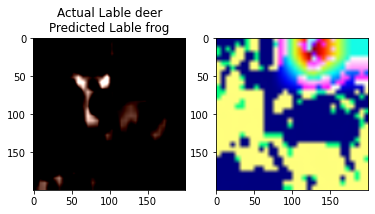

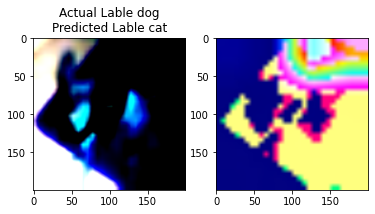

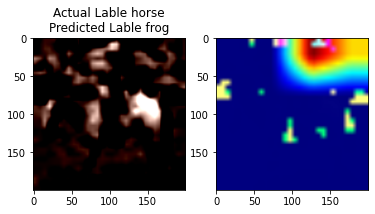

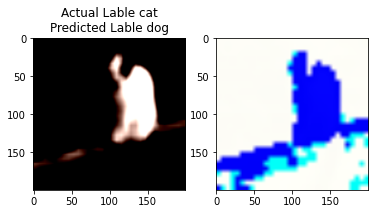

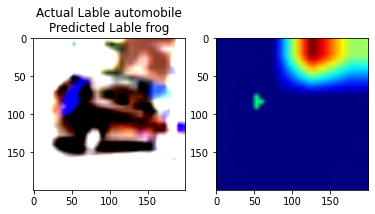

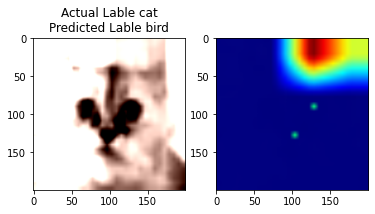

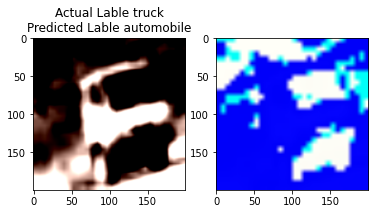

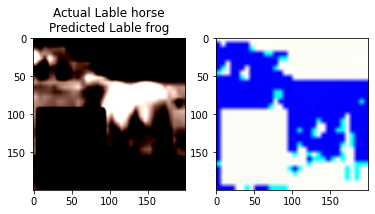

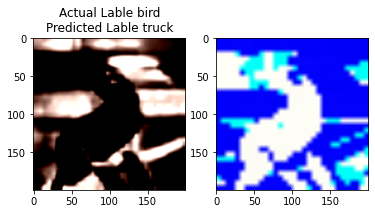

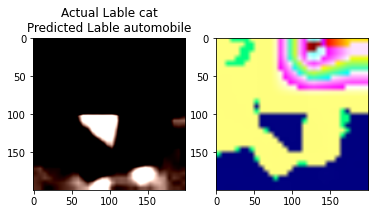

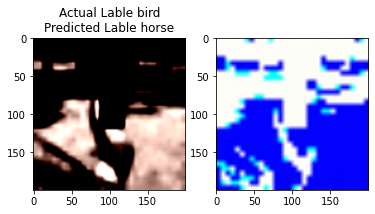

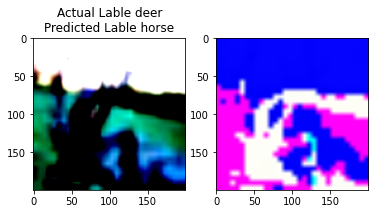

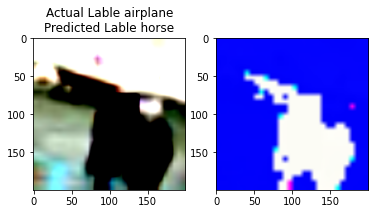

In [11]:
import matplotlib.pyplot as plt
for idx in np.arange(20):
    print(idx) 
    fig, ax1 = plt.subplots(1,2)
    im = missclassifiedimage[idx]
    im=np.moveaxis(im, 0, 2)
    im_resized = cv2.resize(im, (200, 200), interpolation=cv2.INTER_LINEAR)
    cam_im = missclassifiedimage_cam[idx]
    cam_im_resized = cv2.resize(cam_im, (200, 200), interpolation=cv2.INTER_LINEAR)
    ax1[0].imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
    ax1[0].title.set_text(str('Actual Lable ') + classes[missclassifiedimage_actual_label[idx]]+ str('\nPredicted Lable ') + classes[missclassifiedimage_predicted_label[idx]])
    ax1[1].imshow(cv2.cvtColor(cam_im_resized, cv2.COLOR_BGR2RGB))

